In [59]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer



In [60]:
Model_Name   = 'Model_SDP_Conv_Residual_SingleTel_NoPool'
Dataset_Name = 'SDP_Conv2d_OnlyGoodPhi'

#### Loading Data and Models, Processing Predictions

In [61]:
if 'tycho' in hostname:

    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/SDP/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/SDP/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/SDP/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/SDP/Data/'

# append models path to path
sys.path.append(Models_Path)


In [62]:
# Load Model and Tracker Here
Model = torch.load(f'{Models_Path}/{Model_Name}.pt')
Tracker = torch.load(f'{Models_Path}/{Model_Name}_Tracker.pt')
print(Model.Description)


    Convolutional Neural Network for SDP Reconstruction
    Uses standard Conv2d Layers in blocks with residual connections
    Reconstruction is done for one telescope
    This model does not do max pooling
    


In [63]:
# Import Dataset Here

# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
print(Dataset.Name)
print(Dataset.Truth_Keys)
Dataset.AssignIndices()
Dataset.State = 'Test'

Unassigned_CDEsDataset
('SDPTheta', 'SDPPhi')


In [64]:
# Some Information
print(f'Final Epoch             : {len(Tracker.EpochLoss["Total"])  } ')
if len(Tracker.EpochLoss)>10 :
    print(f'Epoch 10 Loss           : {Tracker.EpochLoss    ["Total"][9]} ')
    print(f'Epoch 10 Validation Loss: {Tracker.EpochValLoss ["Total"][9]} ')
print(f'Final Loss              : {Tracker.EpochLoss    ["Total"][-1]}')
print(f'Final Validation Loss   : {Tracker.EpochValLoss ["Total"][-1]}')


Final Epoch             : 25 
Final Loss              : 0.49067712799907504
Final Validation Loss   : 0.5443509817123413


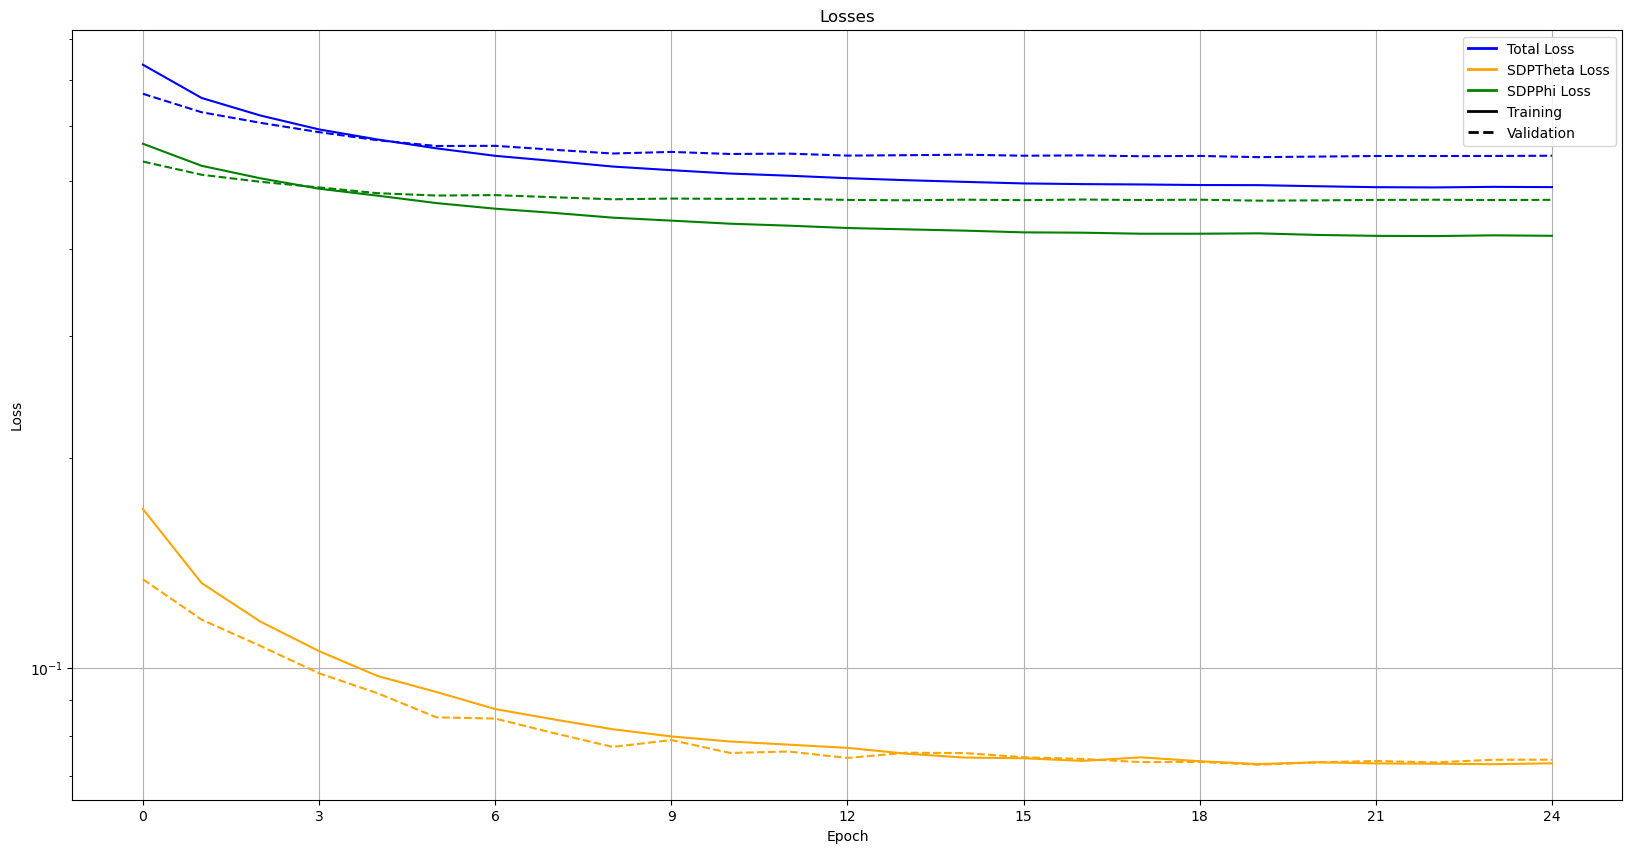

In [65]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

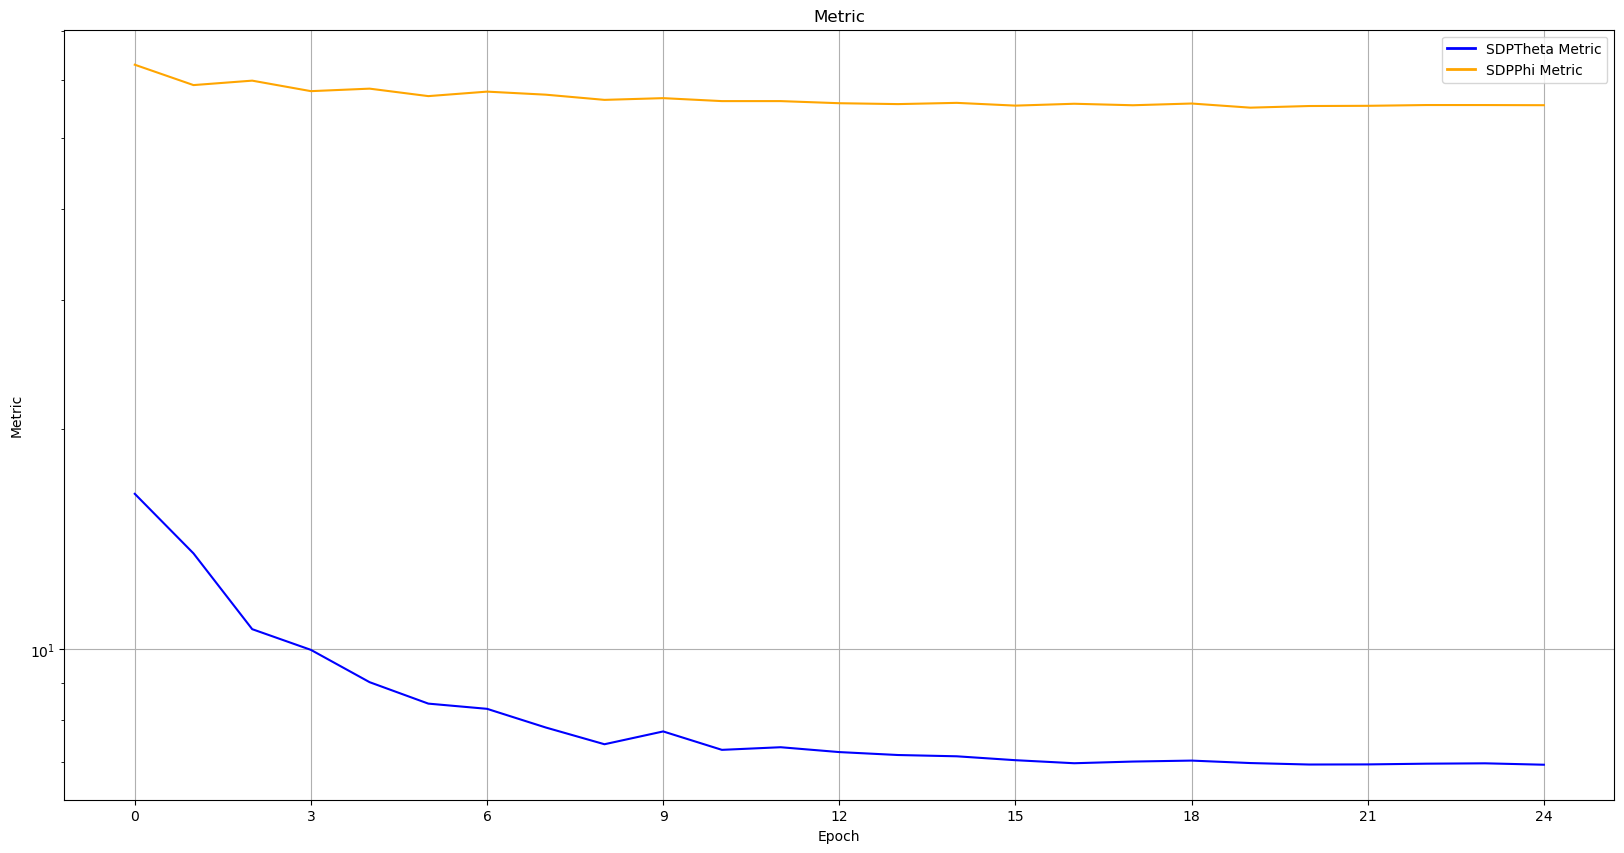

In [66]:
# Metric Plot

# Loss Plot
EpochMetrics    = Tracker.EpochMetric
Keys  = Dataset.Truth_Keys
Units = Dataset.Truth_Units
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    if   Units[i] == 'deg': plt.plot(np.array(EpochMetrics[Keys[i]]), color=colors[i], label=Keys[i] + ' - Metric')
    elif Units[i] == 'rad': plt.plot(np.array(EpochMetrics[Keys[i]])*180/np.pi, color=colors[i], label=Keys[i] + ' - Metric')
    else                  : plt.plot(np.array(EpochMetrics[Keys[i]])/1000     , color=colors[i], label=Keys[i] + ' - Metric')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Metric')



ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Metric')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric')
ax.set_yscale('log')
ax.grid()

In [67]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [68]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        EvI+=1
print()
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    # Looking for nans, sum up all of 2nd dim
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum)
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)




Pred Loss 0.26958829164505005
Rec  Loss 0.24850009381771088
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(21129, 2)
(21129, 2)


In [69]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

Pred68 = []
Rec68  = []

for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec [:,i]),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()


Adjusted Percentile for Pred SDPTheta   6.9516 deg
Adjusted Percentile for Rec  SDPTheta   2.879 deg
Percentile Ratio   Pred/Rec             2.4146

Adjusted Percentile for Pred SDPPhi     55.275 deg
Adjusted Percentile for Rec  SDPPhi     4.0835 deg
Percentile Ratio   Pred/Rec             13.536



#### Not particularly interesing plots

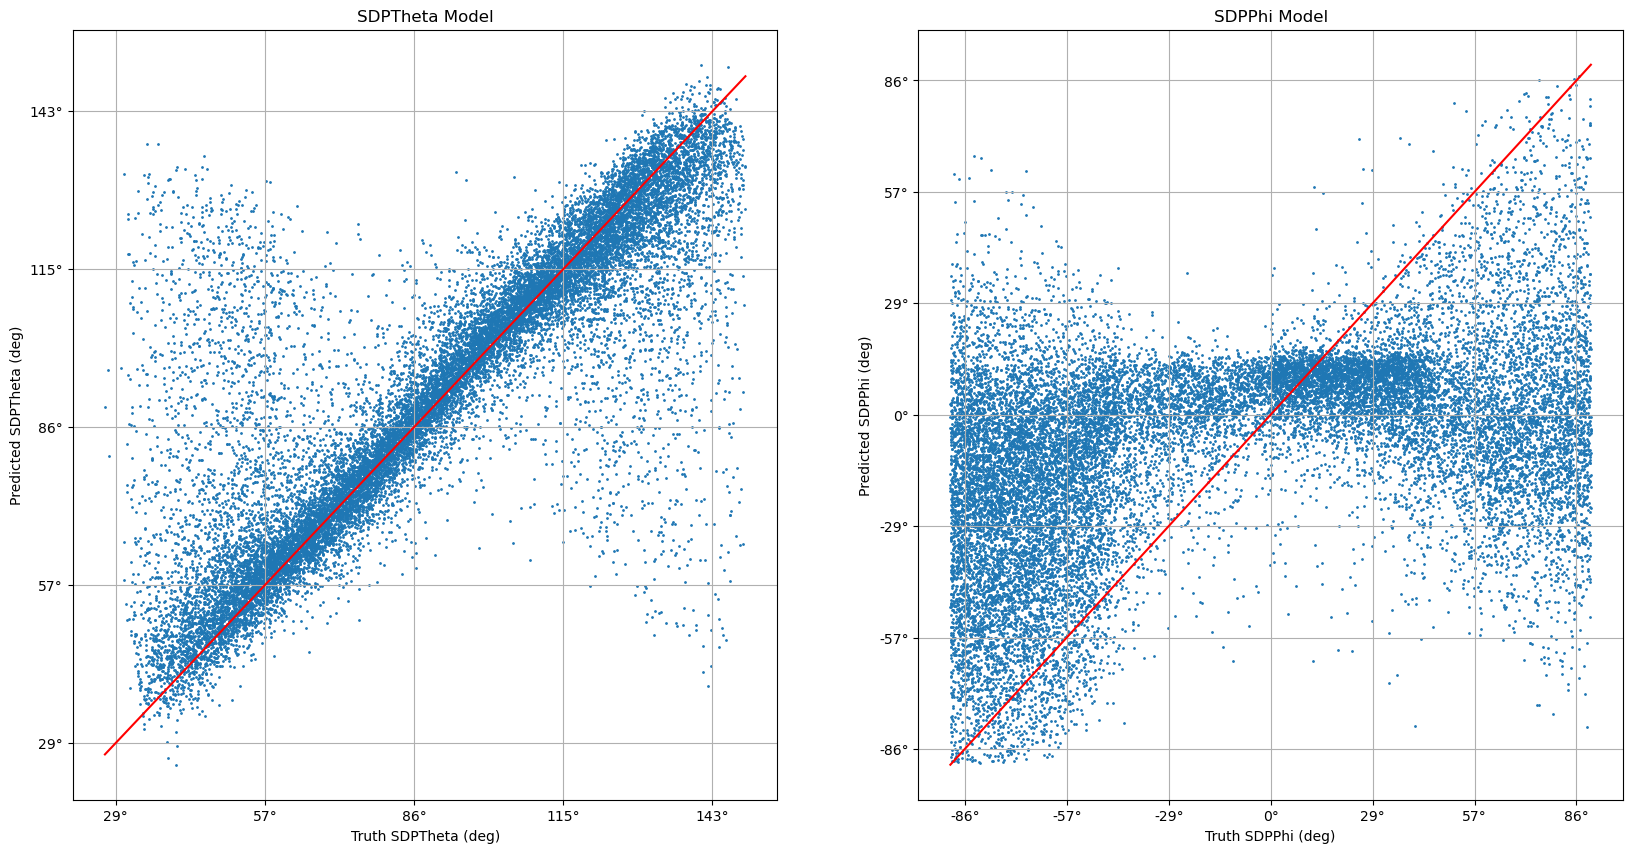

In [70]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


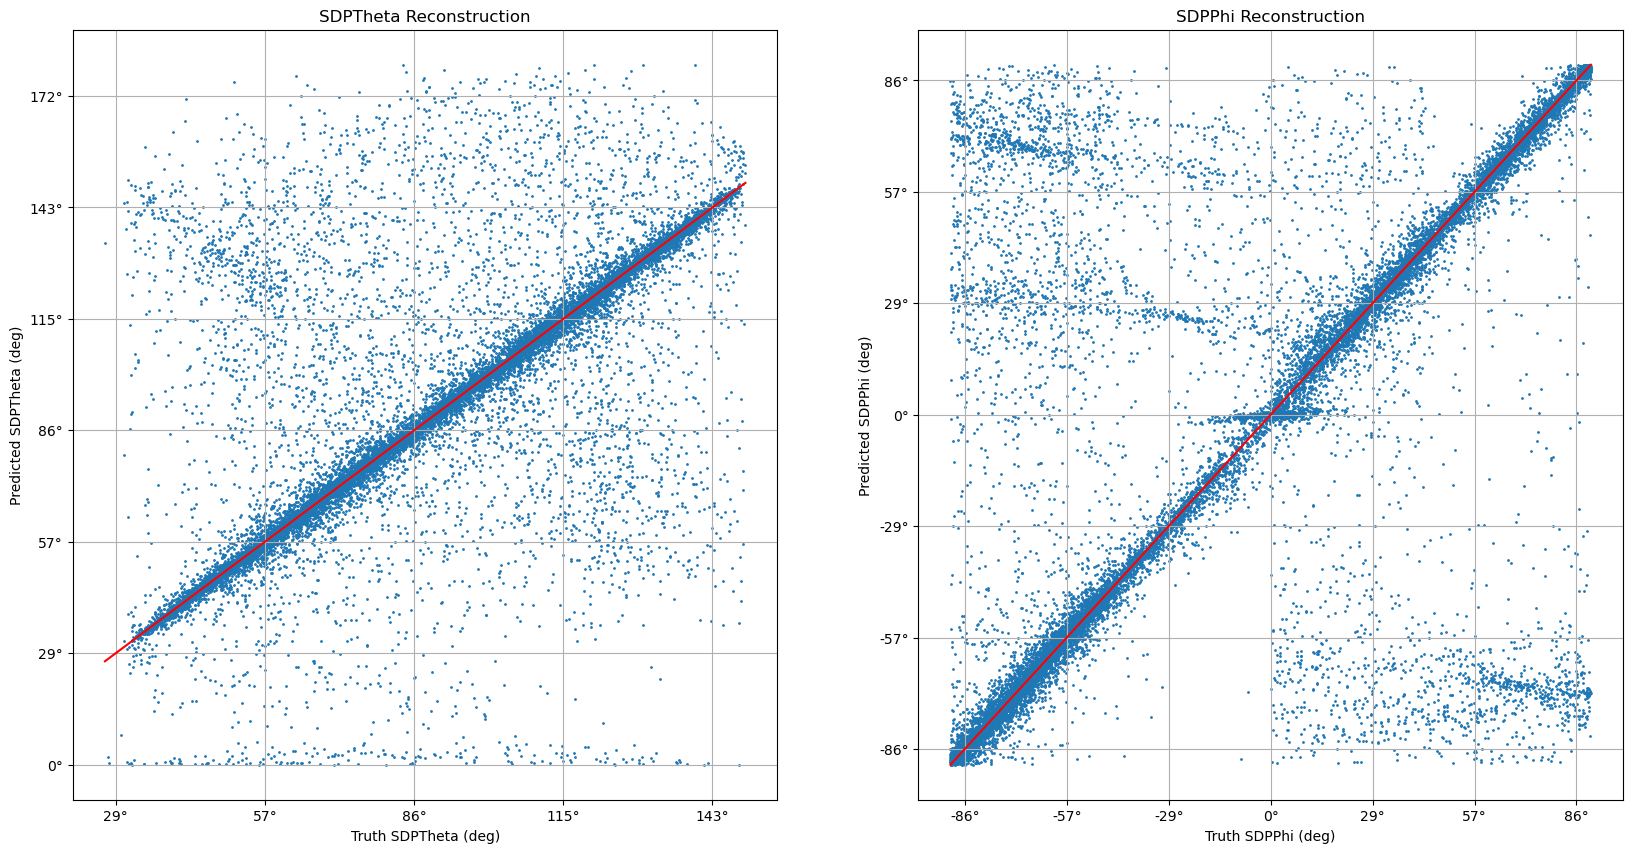

In [71]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


In [72]:
# def DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,Type):
#     fig, ax = plt.subplots(1, len(TruthKeys), figsize=(12.5*len(TruthKeys), 10))
#     for i in range(len(TruthKeys)):
#         X = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
#         Y = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        
        
#         # Scaling Cuts
#         if TruthKeys[i] == 'SDPTheta':
#             cut = (X > 0.1) & (np.abs(Y)<6)
#         elif TruthKeys[i] == 'SDPPhi':
#             cut = (np.abs(Y)<3) & (np.abs(X)<50)
#         elif TruthKeys[i] == 'Chi0':
#             cut = (np.abs(Y)<20)
#         elif TruthKeys[i] == 'Rp':
#             cut = (np.abs(Y)<5000)
#         elif TruthKeys[i] == 'T0':
#             cut = (np.abs(Y)<10000)
#         else:
#             cut = (np.abs(Y)>-1)


#         X = X[cut]
#         Y = Y[cut]

#         sns.scatterplot(x=X, y=Y, ax=ax[i], s=5,color='black')
#         sns.histplot(x=X, y=Y, ax=ax[i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
#         if TruthUnits[i] != 'rad': 
#             ax[i].set_ylabel(f'{Type}-Truth ({TruthUnits[i]})')
#             ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
            
#         else:                      
#             ax[i].set_ylabel(f'{Type}-Truth (degrees)')
#             ax[i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
#         ax[i].set_title(f'{TruthKeys[i]} - {Type}')
#         ax[i].set_xlim(min(X),max(X))
#         ax[i].grid()
#         # 68th Percentile
#         Percentile68 = np.percentile(np.abs(Y),68)
#         # Add as a texbox to top right of plot
#         if TruthUnits[i]!= 'rad': ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)
#         else: ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)

#         ax[i].axhline(Percentile68, color='cyan', linestyle='--')
#         ax[i].axhline(-Percentile68, color='cyan', linestyle='--')

#     return fig
    


In [73]:
# # Deviation Plots
# TruthKeys  = Dataset.Truth_Keys
# TruthUnits = Dataset.Truth_Units

# ModelDeviation = DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,'Model')
# RecDeviation   = DeviationPlot(TruthKeys,TruthUnits,Truth,Rec,'Reconstruction')

# # Save the Figures
# # ModelDeviation.savefig(f'../Results/{Name}_Model_Deviation.png')
# # RecDeviation  .savefig(f'../Results/{Name}_Rec_Deviation.png')

#### More Interesting plots

In [74]:
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)


Total Points before cuts 21129
SDPTheta Total Points after cuts 17601
SDPPhi Total Points after cuts 21129


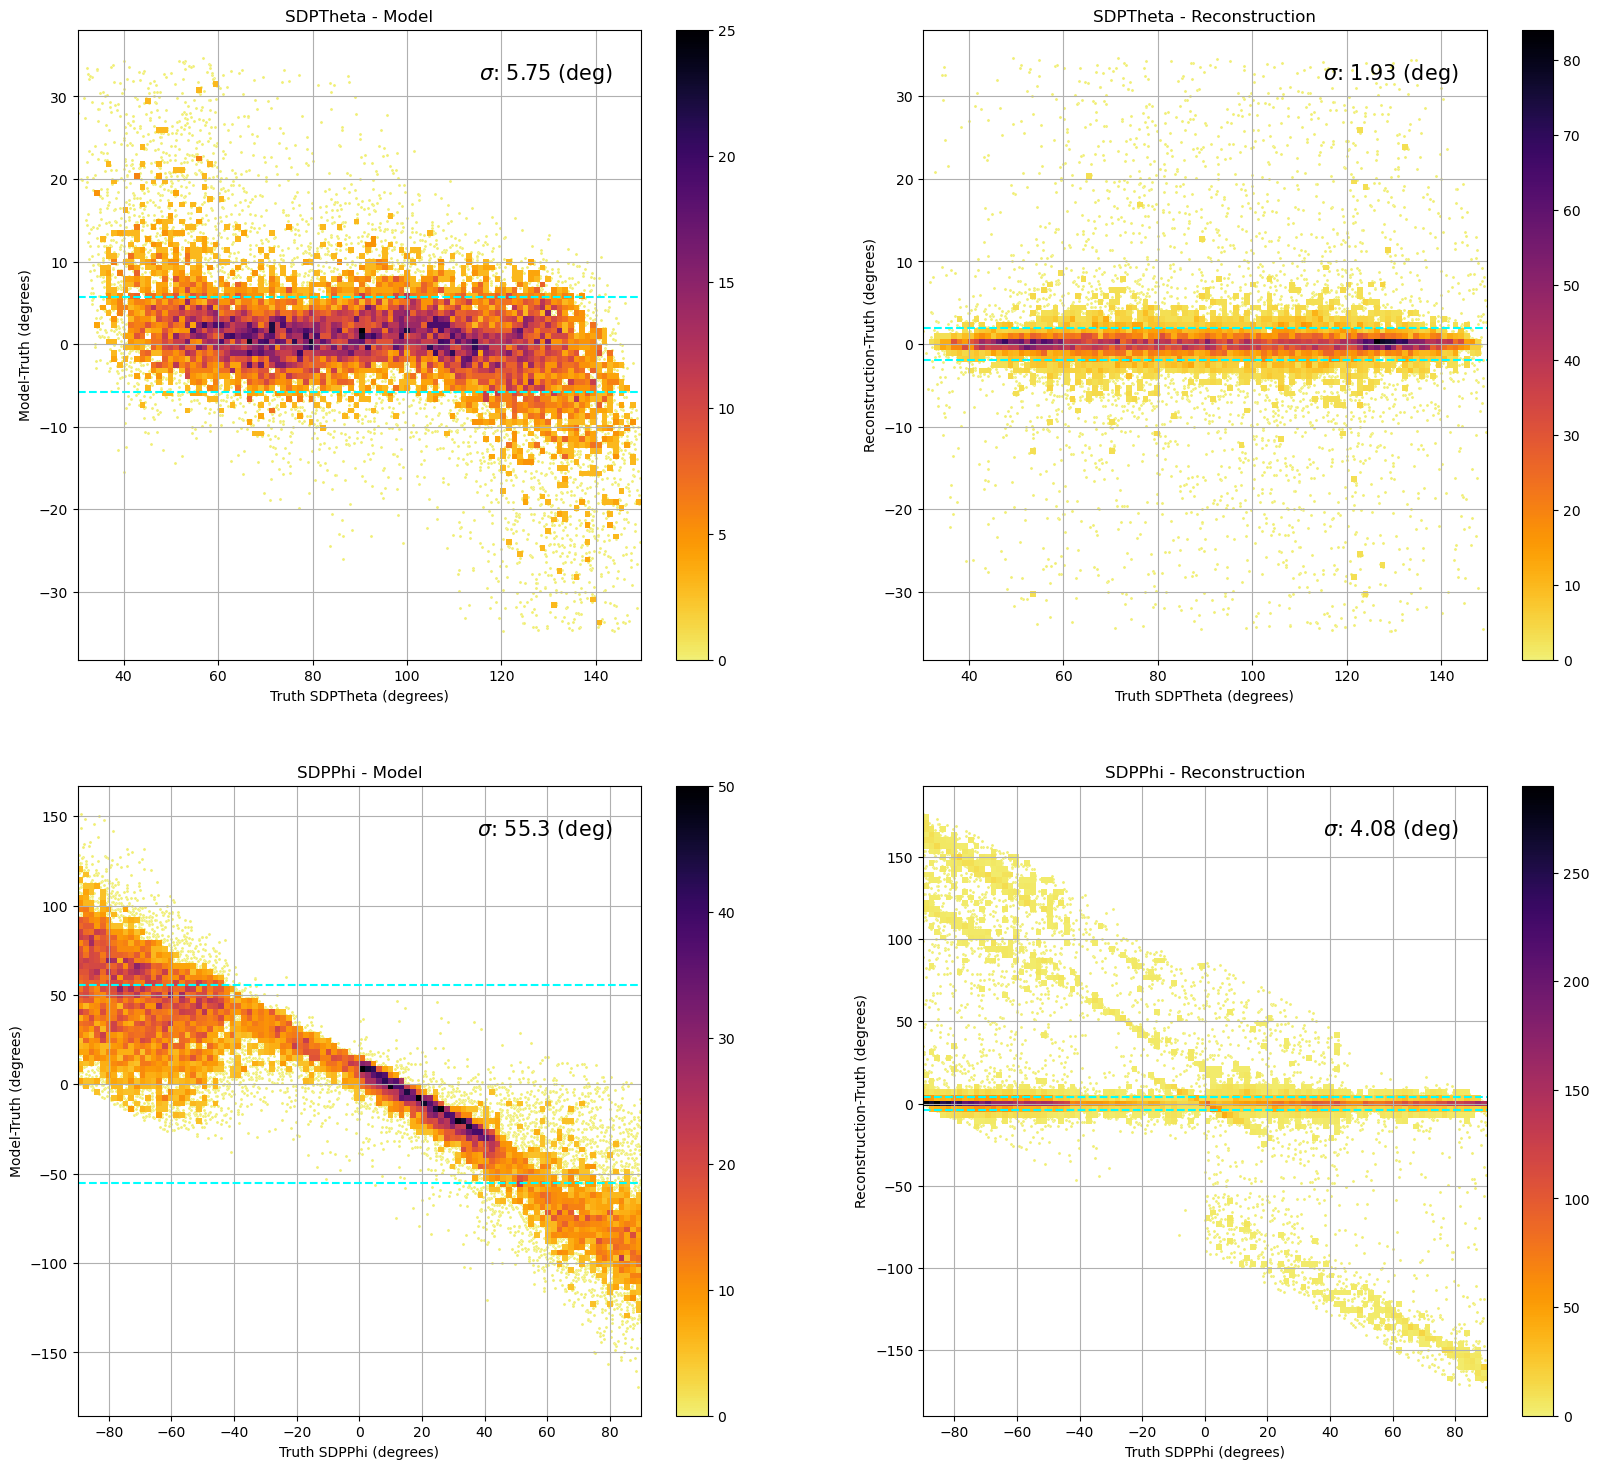

In [75]:
def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (np.abs(Yp)>0) # (np.abs(Yp)<12)    & (np.abs(Yr)<12)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)>0) # (np.abs(Yp)<3)     & (np.abs(Yr)<3) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X  = X [cut]
        Yp = Yp[cut]
        Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)



        ax[i,0].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[i,1].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color='cyan', linestyle='--')
        
    return fig
    
figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

Total Points before cuts 21129
SDPTheta Total Points after cuts 21129
SDPPhi Total Points after cuts 21129


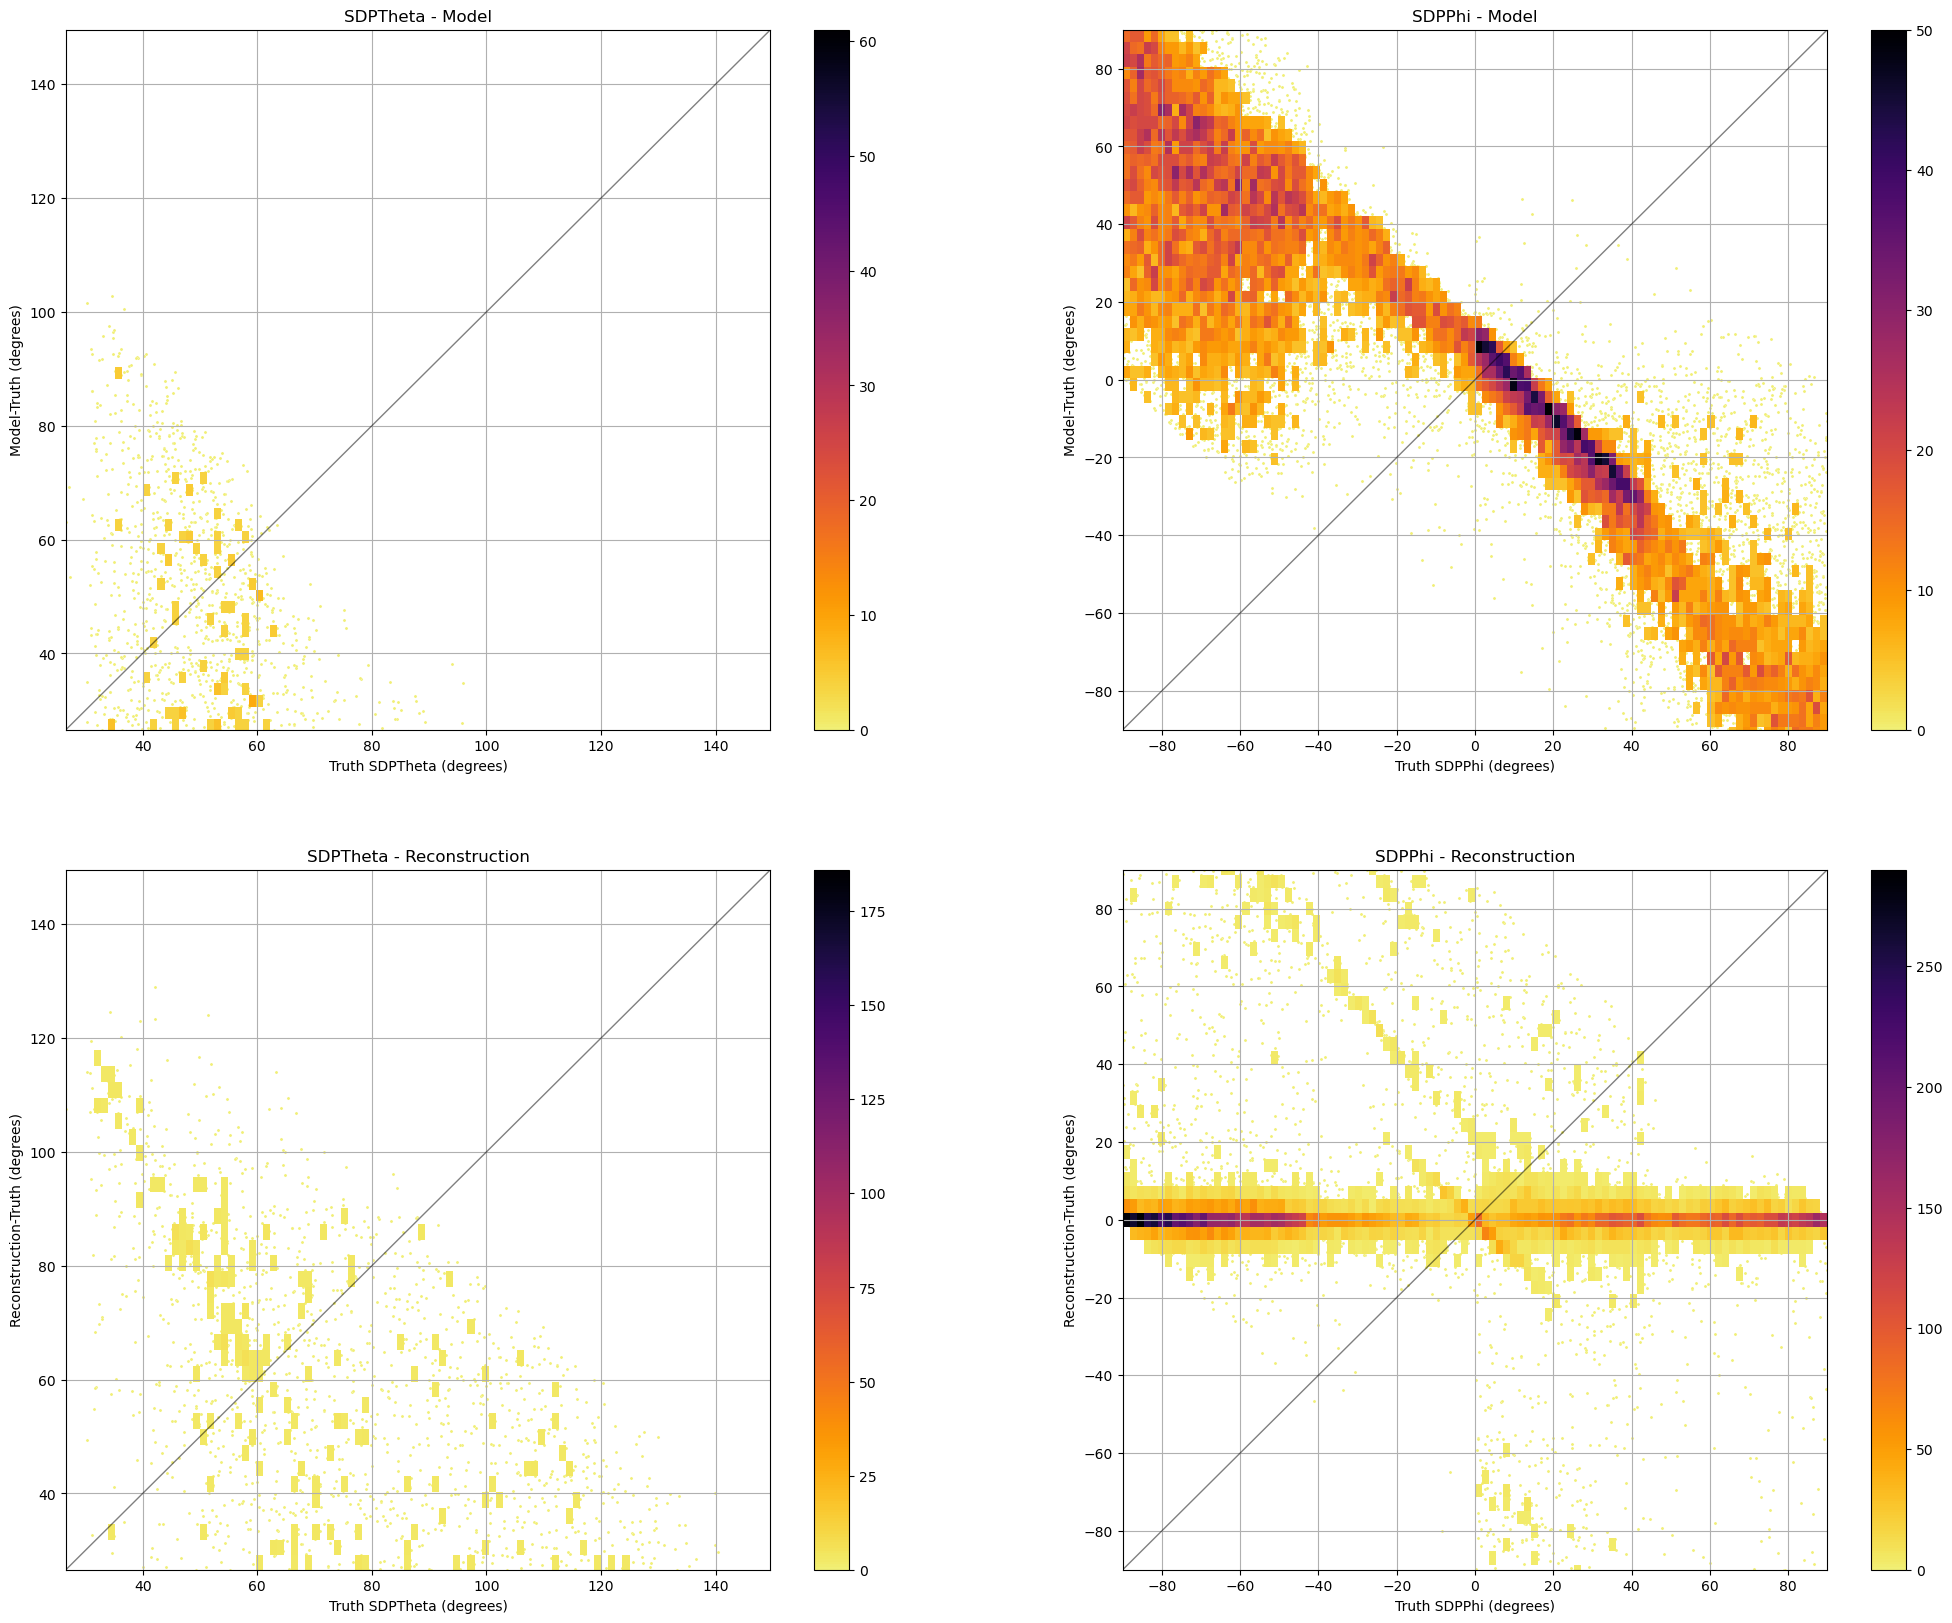

In [18]:
def CombinedNonDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec,FaceColor='white'):
    fig, ax = plt.subplots(2, len(TruthKeys), figsize=(12.5*len(TruthKeys), 20))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        cut = (np.abs(Yp)>-1)
        # if TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        # elif TruthKeys[i] == 'SDPPhi': cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3)    & (np.abs(X)<50)
        # elif TruthKeys[i] == 'Chi0'  : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        # elif TruthKeys[i] == 'Rp'    : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        # elif TruthKeys[i] == 'CEDist': cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        # elif TruthKeys[i] == 'T0'    : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        # # elif TruthKeys[i] == 'Xmax'  : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        # elif TruthKeys[i] == 'LogE'  : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        # elif TruthKeys[i] == 'z'     : cut = (X>0.4) 
        # else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)>-1)# (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # sns.scatterplot(x=X, y=Yp, ax=ax[0,i], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[1,i], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[0,i], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[1,i], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[0,i], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[1,i], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[0,i].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[1,i].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[0,i].set_ylabel(f'Model-Truth (degrees)')
            ax[0,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[1,i].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[1,i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[0,i].set_title(f'{TruthKeys[i]} - Model')
        ax[1,i].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[0,i].set_xlim(min(X),max(X))
        ax[1,i].set_xlim(min(X),max(X))

        ax[0,i].set_ylim(min(X),max(X))
        ax[1,i].set_ylim(min(X),max(X))


        ax[0,i].grid()
        ax[1,i].grid()


        # Truth Line

        ax[0,i].plot([min(X), max(X)], [min(X), max(X)], 'k',linewidth=1,alpha = 0.5)
        ax[1,i].plot([min(X), max(X)], [min(X), max(X)], 'k',linewidth=1,alpha = 0.5)


        ax[0,i].set_facecolor(FaceColor)
        ax[1,i].set_facecolor(FaceColor)

        
    return fig
    
figure = CombinedNonDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
figure.savefig(f'../Results/{Model_Name}_Combined_NonDeviation.png')

#### Other Plots

Sigma Pred:  0.12354069
Sigma Rec :  0.048456643


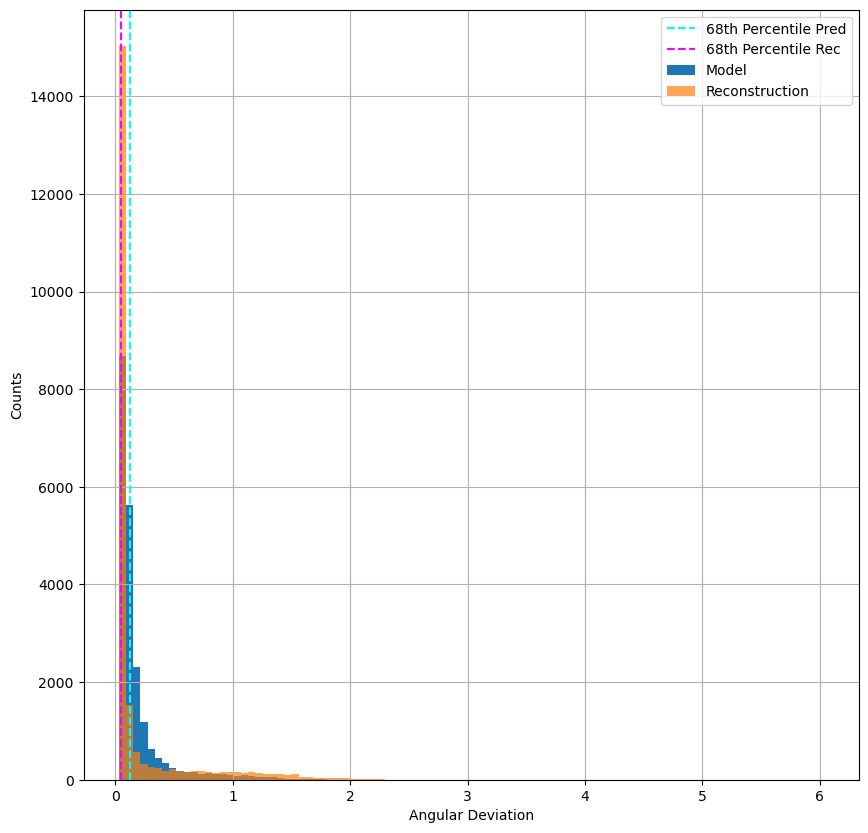

In [19]:
# Angular Deviation of SDP

try:
    SDPTheta_index =  TruthKeys.index('SDPTheta')
    SDPPhi_index   =  TruthKeys.index('SDPPhi')
except:
    pass
# Normalize the vectors to unit vectors
def normalize_vectors(vectors):
    norms = np.linalg.norm(vectors, axis=1)
    return vectors / norms[:, np.newaxis]

# Compute the angular deviation
def compute_angular_deviation(truth, pred, rec):
    truth = normalize_vectors(truth)
    pred = normalize_vectors(pred)
    rec = normalize_vectors(rec)
    

    pred_dot_product = np.einsum('ij,ij->i', truth, pred)
    rec_dot_product = np.einsum('ij,ij->i', truth, rec)
    
    pred_ang_div = np.arccos(np.clip(pred_dot_product, -1.0, 1.0))
    rec_ang_div = np.arccos(np.clip(rec_dot_product, -1.0, 1.0))

    return pred_ang_div, rec_ang_div

def angles_to_vector(Thetas,Phis):
    X = np.sin(Thetas)*np.cos(Phis)
    Y = np.sin(Thetas)*np.sin(Phis)
    Z = np.cos(Thetas)
    return np.array([X,Y,Z]).T




Truth_Vecs = angles_to_vector(np.deg2rad(Truth[:,SDPTheta_index]),np.deg2rad(Truth[:,SDPPhi_index]))
Pred_Vecs  = angles_to_vector(np.deg2rad(Pred [:,SDPTheta_index]),np.deg2rad(Pred [:,SDPPhi_index]))
Rec_Vecs   = angles_to_vector(np.deg2rad(Rec  [:,SDPTheta_index]),np.deg2rad(Rec  [:,SDPPhi_index]))

# Example usage
angular_deviation_pred, angular_deviation_rec = compute_angular_deviation(Truth_Vecs, Pred_Vecs, Rec_Vecs)
# Convert to deg
angular_deviation_pred = np.rad2deg(angular_deviation_pred)
angular_deviation_rec  = np.rad2deg(angular_deviation_rec)

nbins =100
Range = (0,6)

bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])

plt.figure(figsize=(10, 10)) 

counts,bin_edges = np.histogram(angular_deviation_pred, bins=bins)
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model')

counts,bin_edges = np.histogram(angular_deviation_rec, bins=bins)
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction', alpha=0.7)

plt.axvline(np.percentile(angular_deviation_pred, 68), color='cyan', linestyle='--', label='68th Percentile Pred')
plt.axvline(np.percentile(angular_deviation_rec, 68), color='magenta', linestyle='--', label='68th Percentile Rec')
print('Sigma Pred: ',np.percentile(angular_deviation_pred, 68))
print('Sigma Rec : ',np.percentile(angular_deviation_rec, 68))

plt.xlabel('Angular Deviation')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()


Theta : 38.72 deg | Pred : 101.19 deg | Rec : 37.47 deg
Phi   : 29.48 deg | Pred : 9.08 deg | Rec : 24.07 deg


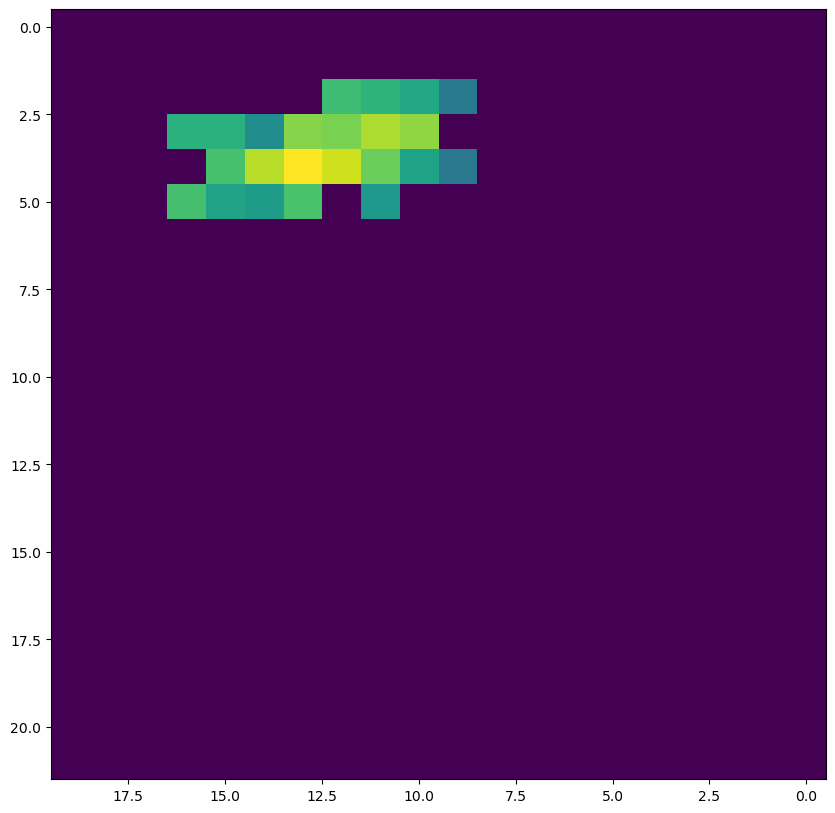

In [83]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 1
Dataset.RandomIter = True
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)
        Pred  = Model(BatchMains, BatchAux).cpu()
        Rec   = BatchRec

        Pred  = Dataset.Unnormalise_Truth(Pred)
        Rec   = Dataset.Unnormalise_Truth(Rec)
        Truth = Dataset.Unnormalise_Truth(BatchTruth)

        Main = BatchMains[0][0]
        Pred = Pred[0]
        Rec  = Rec[0]
        Truth = Truth[0]
        EventIndex = EventIndex[0]
        
        # selecting events where Theta error is really big
        AbsThetaError = np.abs(Truth[Dataset.Truth_Keys.index('SDPTheta')]-Pred[Dataset.Truth_Keys.index('SDPTheta')])
        # print(f'Event {EventIndex} - Theta Error: {AbsThetaError:.2f} deg', end='\r')
        if AbsThetaError > 30* np.pi/180:  # 10 degrees
            break
        else:
            continue
        
# print(f'Event {EventIndex}', end='\r')
print(f'Theta : {Truth[Dataset.Truth_Keys.index("SDPTheta")]*180/np.pi:.2f} deg | Pred : {Pred[Dataset.Truth_Keys.index("SDPTheta")]*180/np.pi:.2f} deg | Rec : {Rec[Dataset.Truth_Keys.index("SDPTheta")]*180/np.pi:.2f} deg')
print(f'Phi   : {Truth[Dataset.Truth_Keys.index("SDPPhi")]*180/np.pi:.2f} deg | Pred : {Pred[Dataset.Truth_Keys.index("SDPPhi")]*180/np.pi:.2f} deg | Rec : {Rec[Dataset.Truth_Keys.index("SDPPhi")]*180/np.pi:.2f} deg')
plt.figure(figsize=(10, 10))
plt.imshow(Main[0,:,:].T, origin='upper', aspect='auto')


plt.gca().invert_xaxis()
# print(Main[Main!=0])